In [430]:
"""
Created on Tuesday 3 April 2022
Author: ZMW
"""
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import pickle
from xgboost import cv
from numpy import mean
from numpy import std
from xgboost import plot_importance
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import shap
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os


### Reading dataset

In [431]:
# data path
path = os.getcwd()
dirname = os.path.dirname(path)

# for window
#data_file = "data\\data.csv"

#for linux
data_file = 'data/data.csv'
data_path = os.path.join(dirname,data_file)

In [432]:
#Load the fitted dataset
data = pd.read_csv(data_path)

In [433]:
data.head()

,Label,Patient,A1_1Deg,A1_1Deg_err,B1_1Deg,B1_1Deg_err,C1_1Deg,C1_1Deg_err,1_Deg_ResSoS_1,1Deg_AdjR2_1,...,8_Deg_ResSoS_1,8Deg_AdjR2_1,A2_8Deg,A2_8Deg_err,B2_8Deg,B2_8Deg_err,C2_8Deg,C2_8Deg_err,8_Deg_ResSoS_2,8Deg_AdjR2_2
0,Not_Parkinson's,PD001,10.388190,0.006132,0.049329,0.000006,0.011989,0.000337,8928.709194,0.990598,...,6698.838281,0.951413,10.273124,0.044206,0.386347,0.000384,0.037356,0.002439,6809.455800,0.939095
1,Not_Parkinson's,PD002,10.429055,0.006929,0.049478,0.000007,0.002837,0.000379,11388.604704,0.988092,...,4769.901822,0.967360,11.482500,0.049154,0.395412,0.000380,-0.002486,0.002419,8383.481840,0.939586
2,Not_Parkinson's,PD003,10.097088,0.005091,0.049368,0.000006,0.005707,0.000287,6140.292312,0.993141,...,3488.747176,0.968709,10.084338,0.019838,0.394595,0.000174,-0.035466,0.001106,1349.962240,0.987259
3,Not_Parkinson's,PD004,10.482881,0.022179,0.049585,0.000023,0.016056,0.001212,117748.979710,0.879372,...,10972.045844,0.920137,11.493414,0.048867,0.401386,0.000377,-0.042463,0.002395,8242.136178,0.940370
4,Not_Parkinson's,PD005,10.181273,0.008833,0.049368,0.000010,0.001569,0.000494,18447.340517,0.979692,...,18268.960666,0.809586,10.370348,0.036121,0.395392,0.000308,-0.030769,0.001960,4485.300264,0.960035


In [434]:
# Standardization
sc = StandardScaler()
data_input = pd.DataFrame(sc.fit_transform(data.iloc[:,2:]),index=data.iloc[:,2:].index, columns= data.iloc[:,2:].columns)

In [435]:
# Features and labels
x = data_input.iloc[:,2:]
y = data.iloc[:,0]


In [436]:
## Convert the categorical variables to number
LabelEncoder_gender = LabelEncoder()
y = LabelEncoder_gender.fit_transform(y)

In [437]:
# spliting feature
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

### Baseline model

In [440]:
#KFold only
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha':3,
            'learning_rate':1.0,
            'n_estimators':100}
model = xgb.XGBClassifier(**params)

all_run = []
for split in range(30):
    #cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=split)
    kfold = KFold(n_splits=5, shuffle=True,random_state=split)
    scores = cross_val_score(model,x,y,scoring='roc_auc', cv=kfold)
    result = [[split,scores.mean()]]
    all_run += result
#print(all_run)
all_run_df = pd.DataFrame(all_run,columns=['split','acc'])
print("XGBoost based model accuracy score: {0:0.4f}".format(all_run_df['acc'].mean()))

XGBoost based model accuracy score: 0.5935


In [441]:
# stratifiedKFold
# create stratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
rf_accu_stratified = []

# Feature Scaling for input features
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# create classifier objects
model = xgb.XGBClassifier()
for train_index, test_index in skf.split(x,y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model.fit(x_train_fold, y_train_fold)
    rf_accu_stratified.append(model.score(x_test_fold, y_test_fold))

print('XGB based model accuracy score: {0:0.4f}'.format(mean(rf_accu_stratified)),'+/-',std(rf_accu_stratified))

XGB based model accuracy score: 0.6167 +/- 0.2793842435706702


### Hyperparameter Tuning

In [408]:
params = {'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
          'gamma': hp.uniform('gamma', 0, 9),
          'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
          'subsample': hp.uniform('subsample', 0.7, 1.0),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
          'max_depth': hp.choice('max_depth', range(3, 18)),
          'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300, 400, 500, 1000])}
    
min_child_weight_ls = range(1, 6)
max_depth_ls = range(3, 18)
n_estimators_ls = [100, 200, 300, 400, 500, 1000, 1500, 2000]

In [409]:
def hyperparameter_tuning(params):
    clf=xgb.XGBClassifier(**params, n_jobs=6, random_state=1, seed=1,
                              use_label_encoder=False)
    clf.fit(x_train, y_train,eval_metric='auc')
    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
#     print ("SCORE:", accuracy) 
    return {'loss': -accuracy, 'status': STATUS_OK }

In [410]:
trials = Trials()

best_hyperparams = fmin(fn = hyperparameter_tuning,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

100%|██████████| 50/50 [00:08<00:00,  5.71trial/s, best loss: -0.8333333333333334]


In [411]:
best_model = xgb.XGBClassifier(n_estimators=n_estimators_ls[best_hyperparams['n_estimators']],
                               max_depth=max_depth_ls[best_hyperparams['max_depth']],
                               min_child_weight=min_child_weight_ls[best_hyperparams['min_child_weight']],
                               learning_rate=best_hyperparams['learning_rate'],
                               gamma=best_hyperparams['gamma'],
                               subsample=best_hyperparams['subsample'],
                               colsample_bytree=best_hyperparams['colsample_bytree'],
                               n_jobs=6, random_state=1, seed=1)
    

In [442]:

#save
file_name = 'hyper_xgb.pkl'
#pickle.dump(best_model, open(file_name,'wb'))

#load
xgb_hyper = pickle.load(open(file_name,'rb'))



### AUC score with tuned parameters

In [443]:
#KFOLD
all_run = []
for split in range(30):
    #cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=split)
    kfold = KFold(n_splits=5, shuffle=True,random_state=split)
    scores = cross_val_score(xgb_hyper,x,y,scoring='roc_auc', cv=kfold)
    result = [[split,scores.mean()]]
    all_run += result
#print(all_run)
all_run_df = pd.DataFrame(all_run,columns=['split','acc'])
print(all_run_df['acc'].mean(),all_run_df['acc'].std())

0.7068910256410257 0.09485193201826382


In [444]:
# create stratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
rf_accu_stratified = []

# Feature Scaling for input features
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

for train_index, test_index in skf.split(x,y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    xgb_hyper.fit(x_train_fold, y_train_fold)
    rf_accu_stratified.append(xgb_hyper.score(x_test_fold, y_test_fold))

print('XGB model with tuned parameters accuracy score: {0:0.4f}'.format(mean(rf_accu_stratified)))

XGB model with tuned parameters accuracy score: 0.6167


### Feature importance

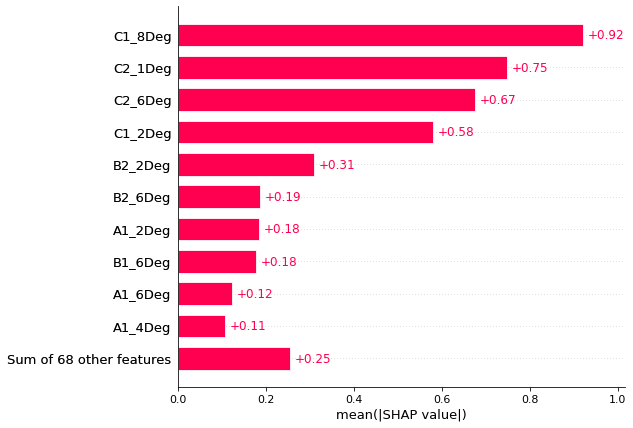

In [379]:
classifier = xgb.XGBClassifier()
classifier.fit(x_train,y_train)
# print the JS visualization code to the notebook
shap.initjs()
explainer = shap.Explainer(classifier)
shap_values = explainer(x_test)
shap.plots.bar(shap_values, max_display=11,show=False)

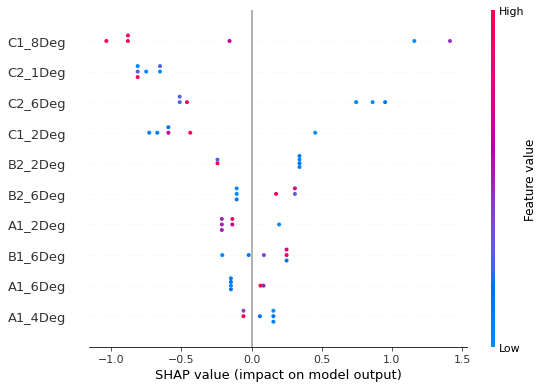

In [257]:
X_importance = x_test
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_importance)
shap.summary_plot(shap_values, X_importance,max_display=10)

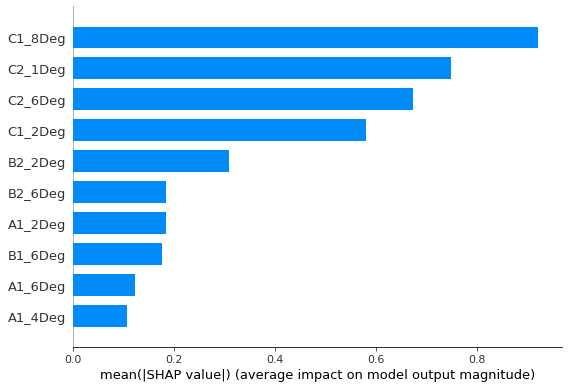

In [255]:
X_importance = x_test
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_importance)
shap.summary_plot(shap_values, X_importance,max_display=10,plot_type='bar')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

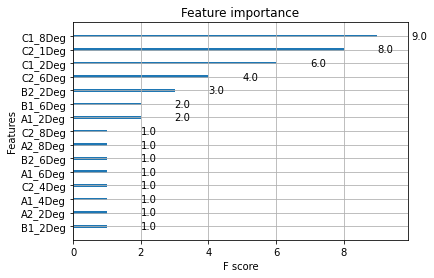

In [260]:
xgb.plot_importance(classifier)

#### KFold with Feature importance

In [445]:
# Kfold
data = data[['Label','Patient','C1_8Deg','C2_1Deg','C2_6Deg',
            'C1_2Deg','B2_2Deg','B2_6Deg','A1_2Deg','B1_6Deg','A1_6Deg','A1_4Deg']]
# data = data[['Label','Patient','B2_6Deg','C2_1Deg','C1_2Deg','C1_8Deg',
#             'C2_6Deg','A1_4Deg','A1_6Deg','A1_2Deg','B2_2Deg','B1_6Deg']]

# data = data[['Label','Patient','C1_8Deg','C2_1Deg','C2_6Deg','C1_2Deg',
#             'B2_2Deg','B2_6Deg','A1_2Deg','B1_6Deg','A1_6Deg','A1_4Deg']]
x = data.iloc[:,2:]
# sc = StandardScaler()
# x = sc.fit_transform(x)
y = data.iloc[:,0]
y = LabelEncoder_gender.fit_transform(y)
# x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
# best_model.fit(x_train, y_train)
#best_model.fit(x,y,eval_metric='auc')
all_run = []
for split in range(30):
    #cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=split)
    kfold = KFold(n_splits=5, shuffle=True,random_state=split)
    scores = cross_val_score(xgb_hyper,x,y,scoring='roc_auc', cv=kfold)
    result = [[split,scores.mean()]]
    all_run += result
#print(all_run)
all_run_df = pd.DataFrame(all_run,columns=['split','acc'])
print(all_run_df['acc'].mean(),all_run_df['acc'].std())
    

0.8152350427350428 0.08195288816413086


### Stratisfied with Feature importance

In [446]:
# data = data[['Label','Patient','C1_8Deg','C2_1Deg','C2_6Deg',
#             'C1_2Deg','B2_2Deg','B2_6Deg','A1_2Deg','B1_6Deg','A1_6Deg','A1_4Deg']]

x = data.iloc[:,2:]
# sc = StandardScaler()
# x = sc.fit_transform(x)
y = data.iloc[:,0]
y = LabelEncoder_gender.fit_transform(y)
# spliting feature
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
# Hyperparameter Tuning function
def hyperparameter_tuning(params):
    clf = xgb.XGBClassifier(**params)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    accuracy = roc_auc_score(y_test, pred>0.5)
#   print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [447]:
# Optimizing
trials = Trials()

best_hyperparams = fmin(fn = hyperparameter_tuning,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

100%|██████████| 50/50 [00:01<00:00, 26.36trial/s, best loss: -0.5]


In [ ]:
# Model with tuned parameters
best_model = xgb.XGBClassifier(n_estimators=n_estimators_ls[best_hyperparams['n_estimators']],
                               max_depth=max_depth_ls[best_hyperparams['max_depth']],
                               min_child_weight=min_child_weight_ls[best_hyperparams['min_child_weight']],
                               learning_rate=best_hyperparams['learning_rate'],
                               gamma=best_hyperparams['gamma'],
                               subsample=best_hyperparams['subsample'],
                               colsample_bytree=best_hyperparams['colsample_bytree'],
                               n_jobs=6, random_state=1, seed=1)

#### Save stratified latest model

In [416]:
file_name = 'hyper_stra_xgb.pkl'
pickle.dump(best_model, open(file_name,'wb'))

#### Load the best model

In [449]:
#save
file_name = 'hyper_stra_xgb.pkl'
#pickle.dump(best_model, open(file_name,'wb'))

#load
xgb_hyper = pickle.load(open(file_name,'rb'))

In [450]:
skf = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1)
xgb_accu_stratified = []

# Feature Scaling for input features
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

#for split in range(50):
#for split in range(10):
for train_index, test_index in skf.split(x,y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    xgb_hyper.fit(x_train_fold, y_train_fold)
    #pred = best_model.predict(x_test_fold)
    accuracy = roc_auc_score(y_test_fold, xgb_hyper.predict_proba(x_test_fold)[:,1])
    xgb_accu_stratified.append(accuracy)

print('XGB model with feature importance accuracy score: {0:0.4f}'.format(mean(xgb_accu_stratified)),std(xgb_accu_stratified))

XGB model with feature importance accuracy score: 0.8250 0.31721443851123804


### Confusion matrix

In [451]:
xgb_hyper.fit(x_train, y_train)
y_pred = xgb_hyper.predict(x_test)
predictions = [round(value) for value in y_pred]

# Accuracy
accuracy = roc_auc_score(y_test,predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.00%


In [452]:
#confusion matrix
confusion = confusion_matrix(y_test,predictions)
print(confusion)

#  Sensitivity 
TP = confusion[1,1] # true positives
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # False positives
FN = confusion[1,0] # false negatives

sensitivity = TP/float(TP+FN)
print(sensitivity)

# Specificity
specificity = TN/float(TN+FP)
print(specificity)


auc_score = roc_auc_score(y_test,predictions)
fpr , tpr , thresholds = roc_curve (y_test, predictions)
print(auc_score)

[[4 0]
 [2 3]]
0.6
1.0
0.8


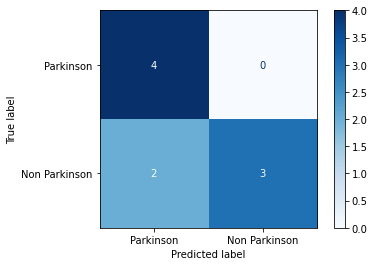

In [453]:
class_names = ['Parkinson','Non Parkinson']
disp = plot_confusion_matrix(xgb_hyper, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

#plt.savefig('cm.png',dpi=300)
plt.show()

#### Learning Curve

[0]	validation_0-error:0.13043	validation_0-logloss:0.66678	validation_1-error:0.50000	validation_1-logloss:0.68941
[1]	validation_0-error:0.13043	validation_0-logloss:0.64268	validation_1-error:0.50000	validation_1-logloss:0.68701
[2]	validation_0-error:0.13043	validation_0-logloss:0.62061	validation_1-error:0.50000	validation_1-logloss:0.68577
[3]	validation_0-error:0.13043	validation_0-logloss:0.59444	validation_1-error:0.50000	validation_1-logloss:0.66231
[4]	validation_0-error:0.13043	validation_0-logloss:0.57527	validation_1-error:0.50000	validation_1-logloss:0.66252
[5]	validation_0-error:0.04348	validation_0-logloss:0.55219	validation_1-error:0.33333	validation_1-logloss:0.64174
[6]	validation_0-error:0.04348	validation_0-logloss:0.53564	validation_1-error:0.33333	validation_1-logloss:0.63942
[7]	validation_0-error:0.04348	validation_0-logloss:0.51513	validation_1-error:0.33333	validation_1-logloss:0.62103
[8]	validation_0-error:0.04348	validation_0-logloss:0.50004	validation_1

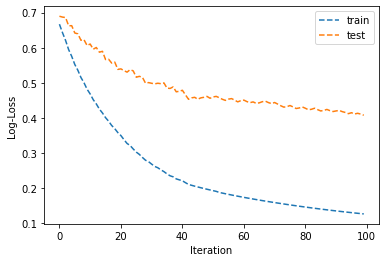

In [455]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=7)
# define the model
model = xgb.XGBClassifier(eta=0.066)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_metric=["error",'logloss'], eval_set=evalset)
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train',ls='--')
plt.plot(results['validation_1']['logloss'], label='test',ls='--')
plt.xlabel('Iteration')
plt.ylabel('Log-Loss')
# show the legend
plt.legend()
# show the plot

#plt.savefig("loss_1.png", format='png', dpi=600)
plt.show()

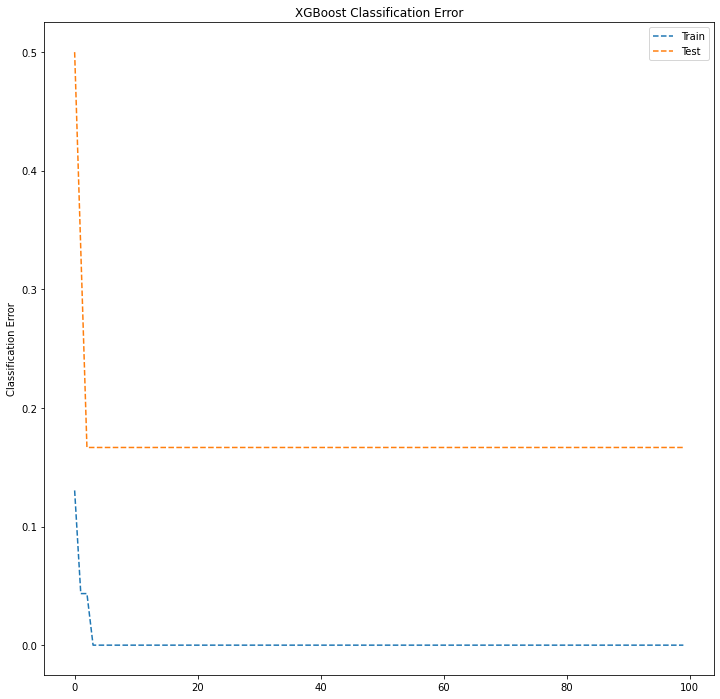

In [437]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(results['validation_0']['error'], label='Train',ls='--')
ax.plot(results['validation_1']['error'], label='Test',ls='--')
ax.legend()

plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [506]:
model = xgb.XGBClassifier(objective= 'binary:logistic')

[0]	validation_0-logloss:0.66273	validation_0-auc:0.86508	validation_0-error:0.17391	validation_1-logloss:0.68533	validation_1-auc:0.80000	validation_1-error:0.33333
[1]	validation_0-logloss:0.63782	validation_0-auc:0.95238	validation_0-error:0.13043	validation_1-logloss:0.67153	validation_1-auc:0.70000	validation_1-error:0.33333
[2]	validation_0-logloss:0.61741	validation_0-auc:1.00000	validation_0-error:0.04348	validation_1-logloss:0.66665	validation_1-auc:0.80000	validation_1-error:0.33333
[3]	validation_0-logloss:0.59615	validation_0-auc:1.00000	validation_0-error:0.04348	validation_1-logloss:0.65684	validation_1-auc:0.80000	validation_1-error:0.33333
[4]	validation_0-logloss:0.57831	validation_0-auc:0.97619	validation_0-error:0.17391	validation_1-logloss:0.65484	validation_1-auc:0.80000	validation_1-error:0.33333
[5]	validation_0-logloss:0.54635	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-logloss:0.62456	validation_1-auc:0.80000	validation_1-error:0.16667
[6]	

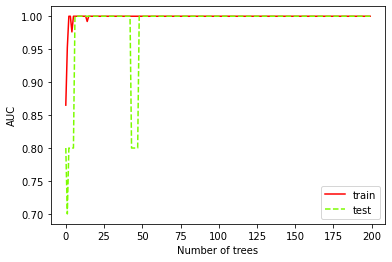

In [53]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=7)
# define the model
#best_model = xgb.XGBClassifier(objective= 'binary:logistic',eta=0.006,n_estimators=300)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
#model = xgb.XGBClassifier(eta=0.066)
# fit the model
best_model.fit(X_train, y_train, eval_metric=['logloss','auc','error'], eval_set=evalset)
# evaluate performance
yhat = best_model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = best_model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['auc'], label='train',color='r')
plt.plot(results['validation_1']['auc'], label='test',color='lawngreen',ls='--')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
# show the legend
plt.legend()
# show the plot

#plt.savefig("auc.png", format='png', dpi=600)
plt.show()

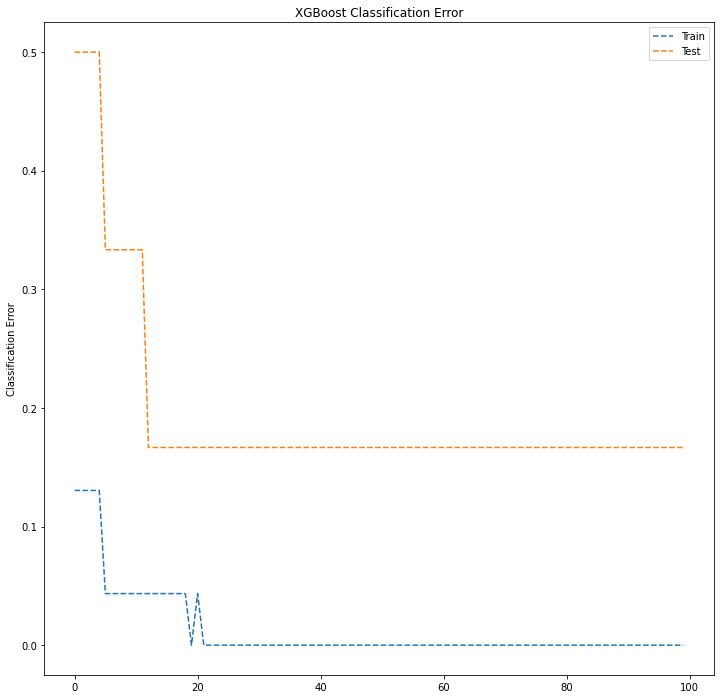

In [477]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(results['validation_0']['error'], label='Train',ls='--')
ax.plot(results['validation_1']['error'], label='Test',ls='--')
ax.legend()

plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

[0]	validation_0-logloss:0.67343	validation_1-logloss:0.69347
[1]	validation_0-logloss:0.65705	validation_1-logloss:0.69325
[2]	validation_0-logloss:0.64165	validation_1-logloss:0.69359
[3]	validation_0-logloss:0.62716	validation_1-logloss:0.69443
[4]	validation_0-logloss:0.61351	validation_1-logloss:0.69574
[5]	validation_0-logloss:0.60064	validation_1-logloss:0.69748
[6]	validation_0-logloss:0.58849	validation_1-logloss:0.69961
[7]	validation_0-logloss:0.57702	validation_1-logloss:0.70209
[8]	validation_0-logloss:0.56619	validation_1-logloss:0.70490
[9]	validation_0-logloss:0.55567	validation_1-logloss:0.70224
[10]	validation_0-logloss:0.54555	validation_1-logloss:0.69615
[11]	validation_0-logloss:0.53559	validation_1-logloss:0.69920
[12]	validation_0-logloss:0.52612	validation_1-logloss:0.69344
[13]	validation_0-logloss:0.51681	validation_1-logloss:0.69668
[14]	validation_0-logloss:0.50780	validation_1-logloss:0.69441
[15]	validation_0-logloss:0.49909	validation_1-logloss:0.69791
[1

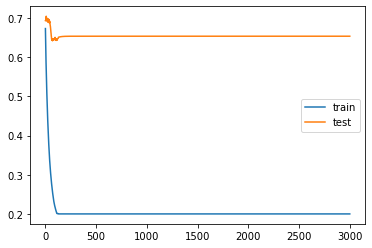

In [413]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.50, random_state=2)
# define the model
model = xgb.XGBClassifier(n_estimators=3000,eta=0.05)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()